In [144]:
#import required libraries
import geopandas as gpd
import rasterio
from rasterio import plot
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, ogr
import json
import os
from os import listdir
from os.path import isfile, isdir, join
import math
from pprint import pprint
import shutil
import sys
import zipfile
import requests
import io
import webbrowser
import ee
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

np.seterr(divide='ignore', invalid='ignore')
# https://stackoverflow.com/questions/51390968/python-ssl-certificate-verify-error
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [6]:
# Connect to Google Earth Engine API
# This will open a web page where you have to enter your account information and a code is provided. Paste it in the terminal.
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [7]:
# Functions modified from climada.util.earth_engine module
def obtain_image_landsat_composite(collection, time_range, area):
    """ Selection of Landsat cloud-free composites in the Earth Engine library
    See also: https://developers.google.com/earth-engine/landsat

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_composite (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_composite = ee.Algorithms.Landsat.simpleComposite(image_area, 75, 3)
    return image_composite

def obtain_image_median(collection, time_range, area):
    """ Selection of median from a collection of images in the Earth Engine library
    See also: https://developers.google.com/earth-engine/reducers_image_collection

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_median (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_median = image_area.median()
    return image_median

'''
The function below has been modified to accept the cloud cover threshold as an input
'''
def obtain_image_sentinel(collection, time_range, area, clouds):
    """ Selection of median, cloud-free image from a collection of images in the Sentinel 2 dataset
    See also: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        sentinel_median (ee.image.Image)
     """
#First, method to remove cloud from the image
    def maskclouds(image):
        band_qa = image.select('QA60')
        cloud_mask = ee.Number(2).pow(10).int()
        cirrus_mask = ee.Number(2).pow(11).int()
        mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
            band_qa.bitwiseAnd(cirrus_mask).eq(0))
        return image.updateMask(mask).divide(10000)

    sentinel_filtered = (ee.ImageCollection(collection).
                         filterBounds(area).
                         filterDate(time_range[0], time_range[1]).
                         filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', clouds)).
                         map(maskclouds))

    sentinel_median = sentinel_filtered.median()
    return sentinel_median

def get_region(geom):
    """Get the region of a given geometry, needed for exporting tasks.

    Parameters:
        geom (ee.Geometry, ee.Feature, ee.Image): region of interest

    Returns:
        region (list)
    """
    if isinstance(geom, ee.Geometry):
        region = geom.getInfo()["coordinates"]
    elif isinstance(geom, ee.Feature, ee.Image):
        region = geom.geometry().getInfo()["coordinates"]
    elif isinstance(geom, list):
        condition = all([isinstance(item) == list for item in geom])
        if condition:
            region = geom
    return region

def get_url(name, image, scale, region, filePerBand=False):
    """It will open and download automatically a zip folder containing Geotiff data of 'image'.
    Parameters:
        name -  a base name to use when constructing filenames.
        image (ee.image.Image): image to export
        scale (int): resolution of export in meters (e.g: 30 for Landsat)
        region (list): region of interest
        filePerBand - whether to produce a different GeoTIFF per band (boolean).
            Defaults to true. If false, a single GeoTIFF is produced and all
            band-level transformations will be ignored.

    Returns:
        path (str)


    If additional parameters are needed, see also:
    https://github.com/google/earthengine-api/blob/master/python/ee/image.py

    Args:
        params: An object containing visualization options with the following
          possible values:
        name -  a base name to use when constructing filenames.
        bands -  a description of the bands to download. Must be an array of
            dictionaries, each with the following keys:
          id -  the name of the band, a string, required.
          crs -  an optional CRS string defining the band projection.
          crs_transform -  an optional array of 6 numbers specifying an affine
              transform from the specified CRS, in the order: xScale, yShearing,
              xShearing, yScale, xTranslation and yTranslation.
          dimensions -  an optional array of two integers defining the width and
              height to which the band is cropped.
          scale -  an optional number, specifying the scale in meters of the
                 band; ignored if crs and crs_transform is specified.
        crs -  a default CRS string to use for any bands that do not explicitly
            specify one.
        crs_transform -  a default affine transform to use for any bands that do
            not specify one, of the same format as the crs_transform of bands.
        dimensions -  default image cropping dimensions to use for any bands
            that do not specify them.
        scale -  a default scale to use for any bands that do not specify one;
            ignored if crs and crs_transform is specified.
        region -  a polygon specifying a region to download; ignored if crs
            and crs_transform is specified.
        filePerBand - whether to produce a different GeoTIFF per band (boolean).
            Defaults to true. If false, a single GeoTIFF is produced and all
            band-level transformations will be ignored.
     """
    path = image.getDownloadURL({
        'name':(name),
        'scale': scale,
        'region':(region),
        'filePerBand': (filePerBand)
        })

    webbrowser.open_new_tab(path)
    return path


Part-2

In [35]:
# EDIT THE SEARCH OPTIONS BELOW

# YOU CAN PLACE A DIFFERENT SHAPEFILE ONTO YOUR GOOGLE DRIVE BUT MAKE SURE THAT
#    THE VARIABLE shapefile POINTS TO THE CORRECT FILE:
shapefile = '/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_shapefile/POLYGON.shp' # ESRI Shapefile of the study area

# Define a date range for our search
datefrom = '2022-01-01' # start date for imagery search
dateto   = '2022-12-30' # end date for imagery searchA
time_range = [datefrom, dateto] # format as a list

# Define which cloud cover we accept in the images
clouds = 10 # maximum acceptable cloud cover in %

driver = ogr.GetDriverByName("Esri Shapefile")
ds = driver.Open(shapefile, 0)
lyr = ds.GetLayer()
extent = lyr.GetExtent()
print("Extent of the area of interest (shapefile):\n", extent)
print(type(extent))
outSpatialRef = lyr.GetSpatialRef().ExportToWkt()
ds = None
print("\nSpatial referencing information of the shapefile:\n", outSpatialRef)
# GEE needs a special format for defining an area of interest. 
# It has to be a GeoJSON Polygon and the coordinates should be first defined in a list and then converted using ee.Geometry. 

extent_list = list(extent)
print(extent_list)
print(type(extent_list))

area_list = list([(extent[0], extent[2]),
                  (extent[1], extent[2]),
                  (extent[1], extent[3]),
                  (extent[0], extent[3]),
                  (extent[0], extent[2])])
print(area_list)
print(type(area_list))
search_area = ee.Geometry.Polygon(area_list)
print(search_area)
print(type(search_area))

s2collection = ('COPERNICUS/S2')
s2median = obtain_image_sentinel(s2collection, time_range, search_area, clouds)
bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12']
print(bands)
# spatial resolution of the downloaded data
resolution = 20 # in units of metres

Extent of the area of interest (shapefile):
 (0.2510902949725562, 0.3724681237059144, 51.441322457120236, 51.48555306333347)
<class 'tuple'>

Spatial referencing information of the shapefile:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
[0.2510902949725562, 0.3724681237059144, 51.441322457120236, 51.48555306333347]
<class 'list'>
[(0.2510902949725562, 51.441322457120236), (0.3724681237059144, 51.441322457120236), (0.3724681237059144, 51.48555306333347), (0.2510902949725562, 51.48555306333347), (0.2510902949725562, 51.441322457120236)]
<class 'list'>
ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
       

In [36]:
search_region = get_region(search_area)
s2url = get_url('thames_2022',s2median.select(bands), resolution, search_region, filePerBand=True)
print(s2url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ef369db06c35d977032a922bcae7818-d48926922c0ea0045b3fc6690ad314f2:getPixels


Part3

In [95]:
floodbands = glob("/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/*B?*.tif")
floodbands.sort()
for i in floodbands:
    print(i)

/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B01.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B02.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B03.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B04.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B05.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B06.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B07.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B08.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B09.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B10.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B11.tif
/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_2022/thames_2022.B12.tif


In [96]:
l = []
for i in floodbands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

arr_bef = np.stack(l)

In [97]:
arr_bef.shape

(12, 247, 677)

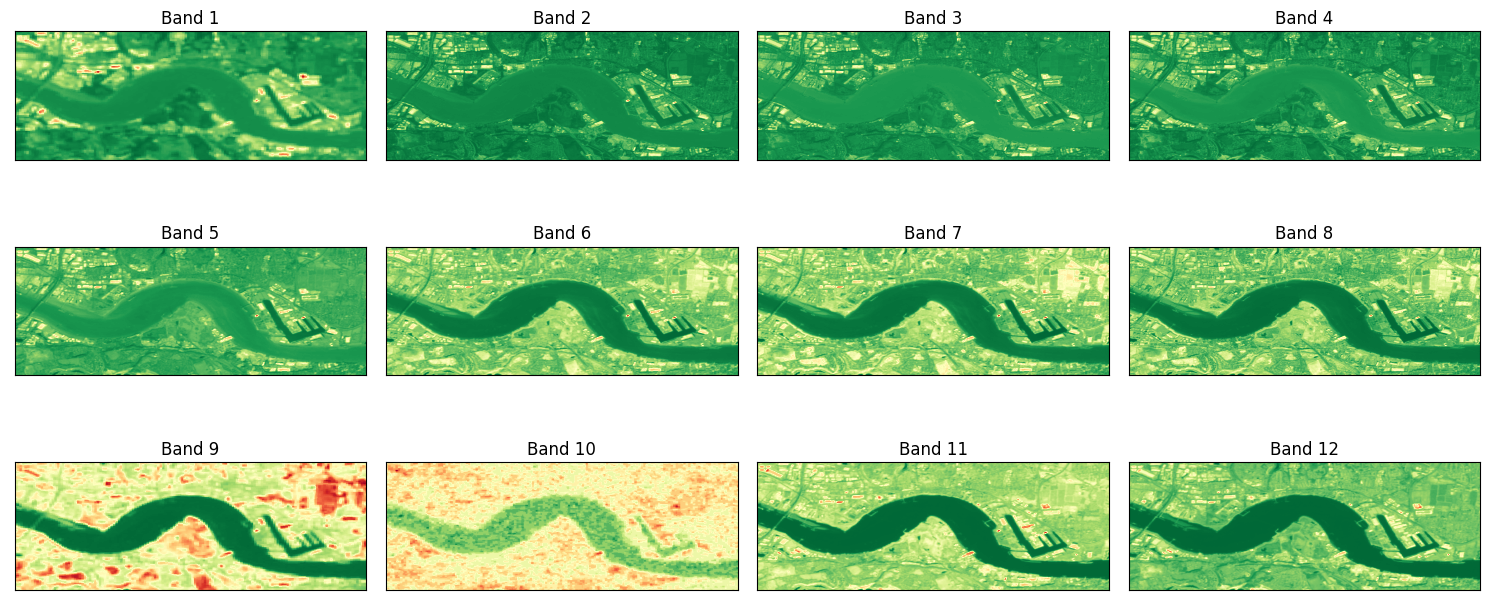

In [98]:
ep.plot_bands(arr_bef,
              cmap='RdYlGn_r',
              cols=4,
              figsize=(15, 7),
              cbar=False)
plt.show()

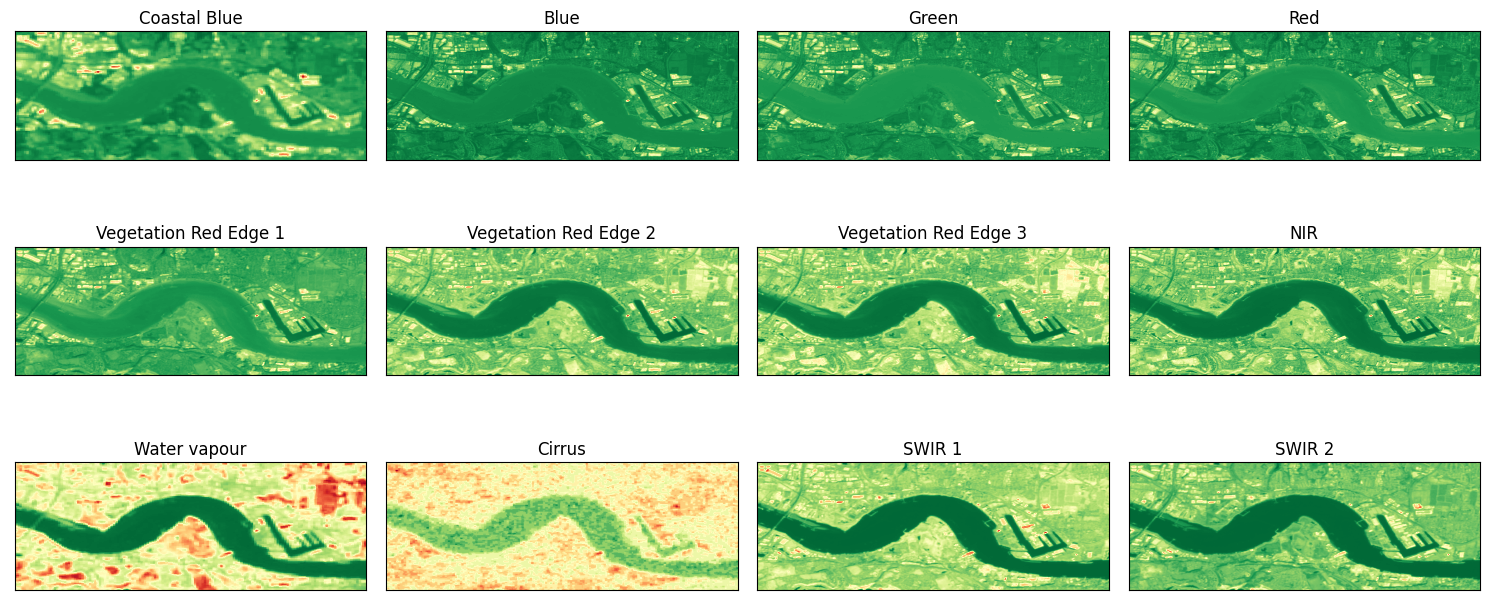

In [99]:
titles = ["Coastal Blue", "Blue", "Green",
          "Red", "Vegetation Red Edge 1", "Vegetation Red Edge 2",
          "Vegetation Red Edge 3", "NIR", "Water vapour",
          "Cirrus", "SWIR 1", "SWIR 2"]

ep.plot_bands(arr_bef,
              cmap='RdYlGn_r',
              cols=4,
              figsize=(15, 7),
              cbar=False,
              title = titles)
plt.show()

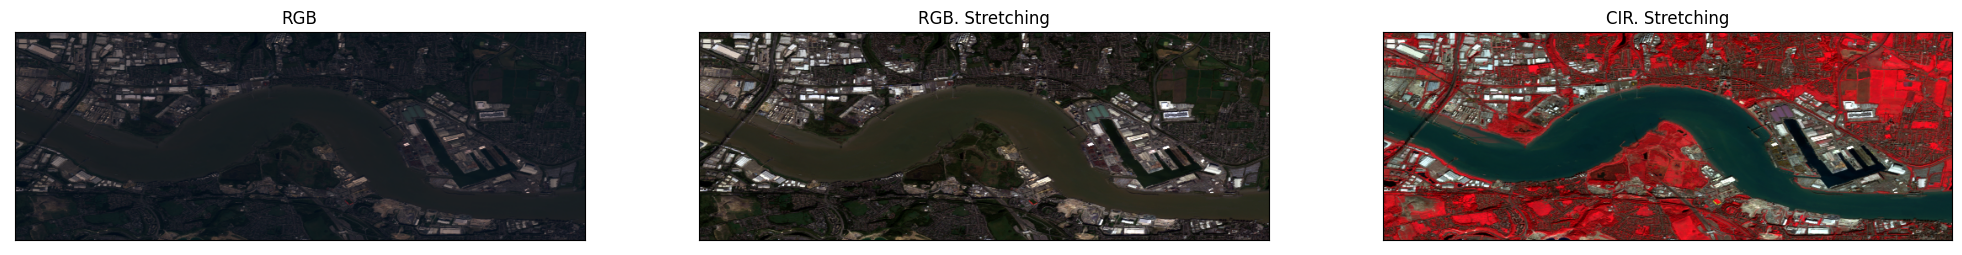

In [100]:
# Create figure with three plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

# Plot of RGB composite without stretching
ax1=ep.plot_rgb(arr_bef,
            rgb=(3, 2, 1),
            ax=ax1,
            figsize=(10, 4),
            title="RGB")

# Plot of RGB composite with stretching
ax2=ep.plot_rgb(arr_bef,
            rgb=(3, 2, 1),
            ax=ax2,
            stretch=True,
            str_clip=0.2,
            figsize=(10, 4),
            title="RGB. Stretching")

# Plot of CIR composite image with stretching
ax3 = ep.plot_rgb(
    arr_bef,
    rgb=(7, 3, 2),
    ax=ax3,
    stretch=True,
    str_clip=0.5,
    figsize=(10, 4),
    title="CIR. Stretching"
)
plt.show()

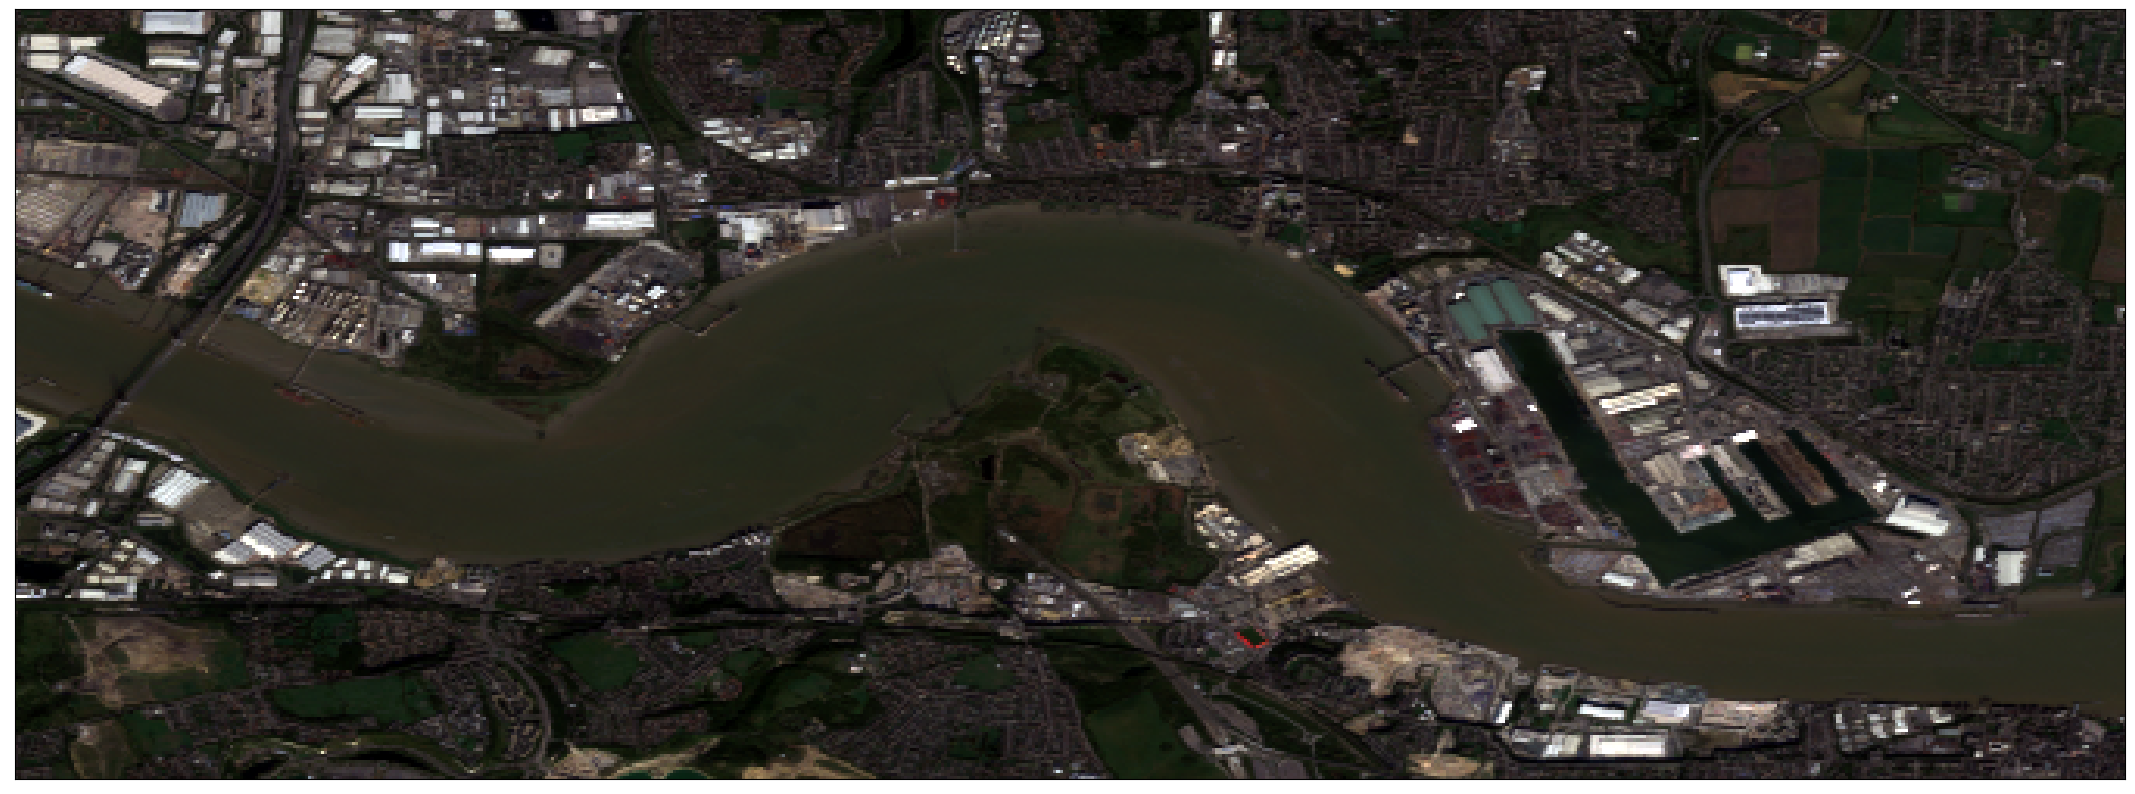

In [101]:
# RGB Composite Image with Stretching Histogram to make pixels brighter
ep.plot_rgb(arr_bef,
            rgb=(3, 2, 1),
            stretch=True,
            str_clip=0.2,
            figsize=(60, 10))
plt.show()

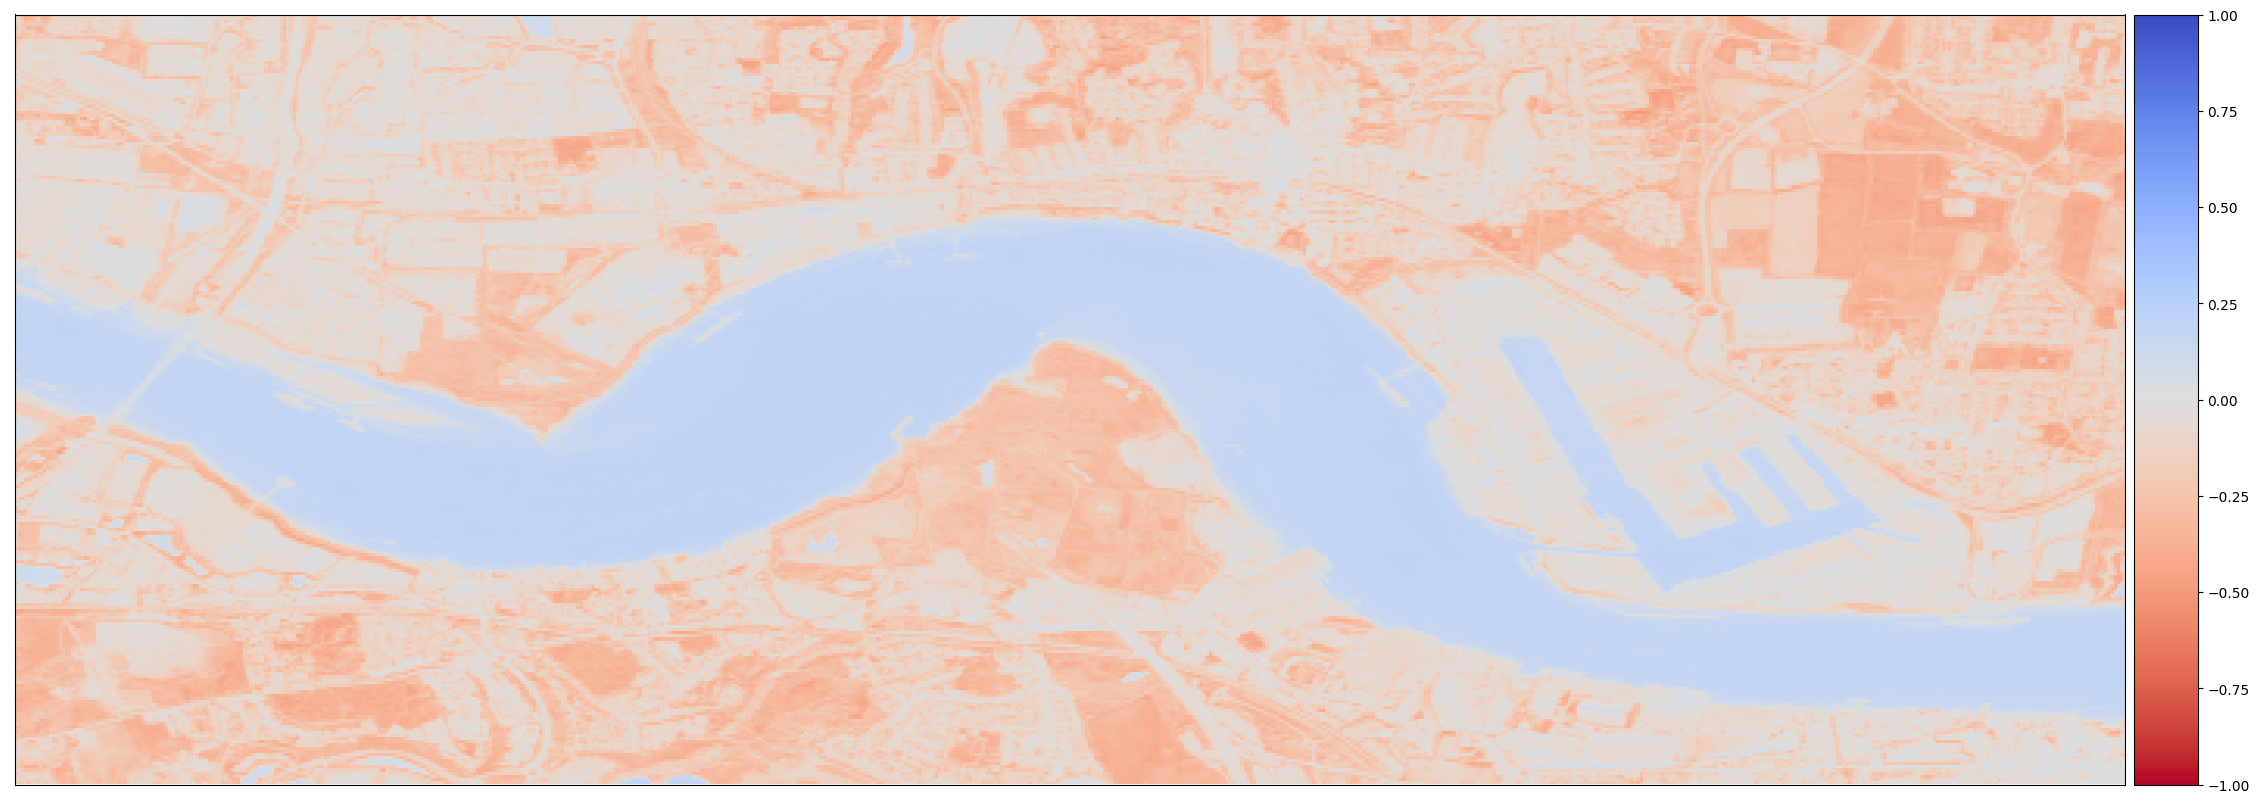

In [119]:
# Green is the 3rd band, but 3-1=2 in a python list, starting from 0
# NIR is the 8th band, but 8-1=7 in a python list, starting from 0

ndwi2 = es.normalized_diff(b1=arr_bef[2],
                              b2=arr_bef[7])
ep.plot_bands(ndwi2,
              cmap='coolwarm_r',
              vmin=-1,
              vmax=1,
              figsize=(60, 10))
plt.show()

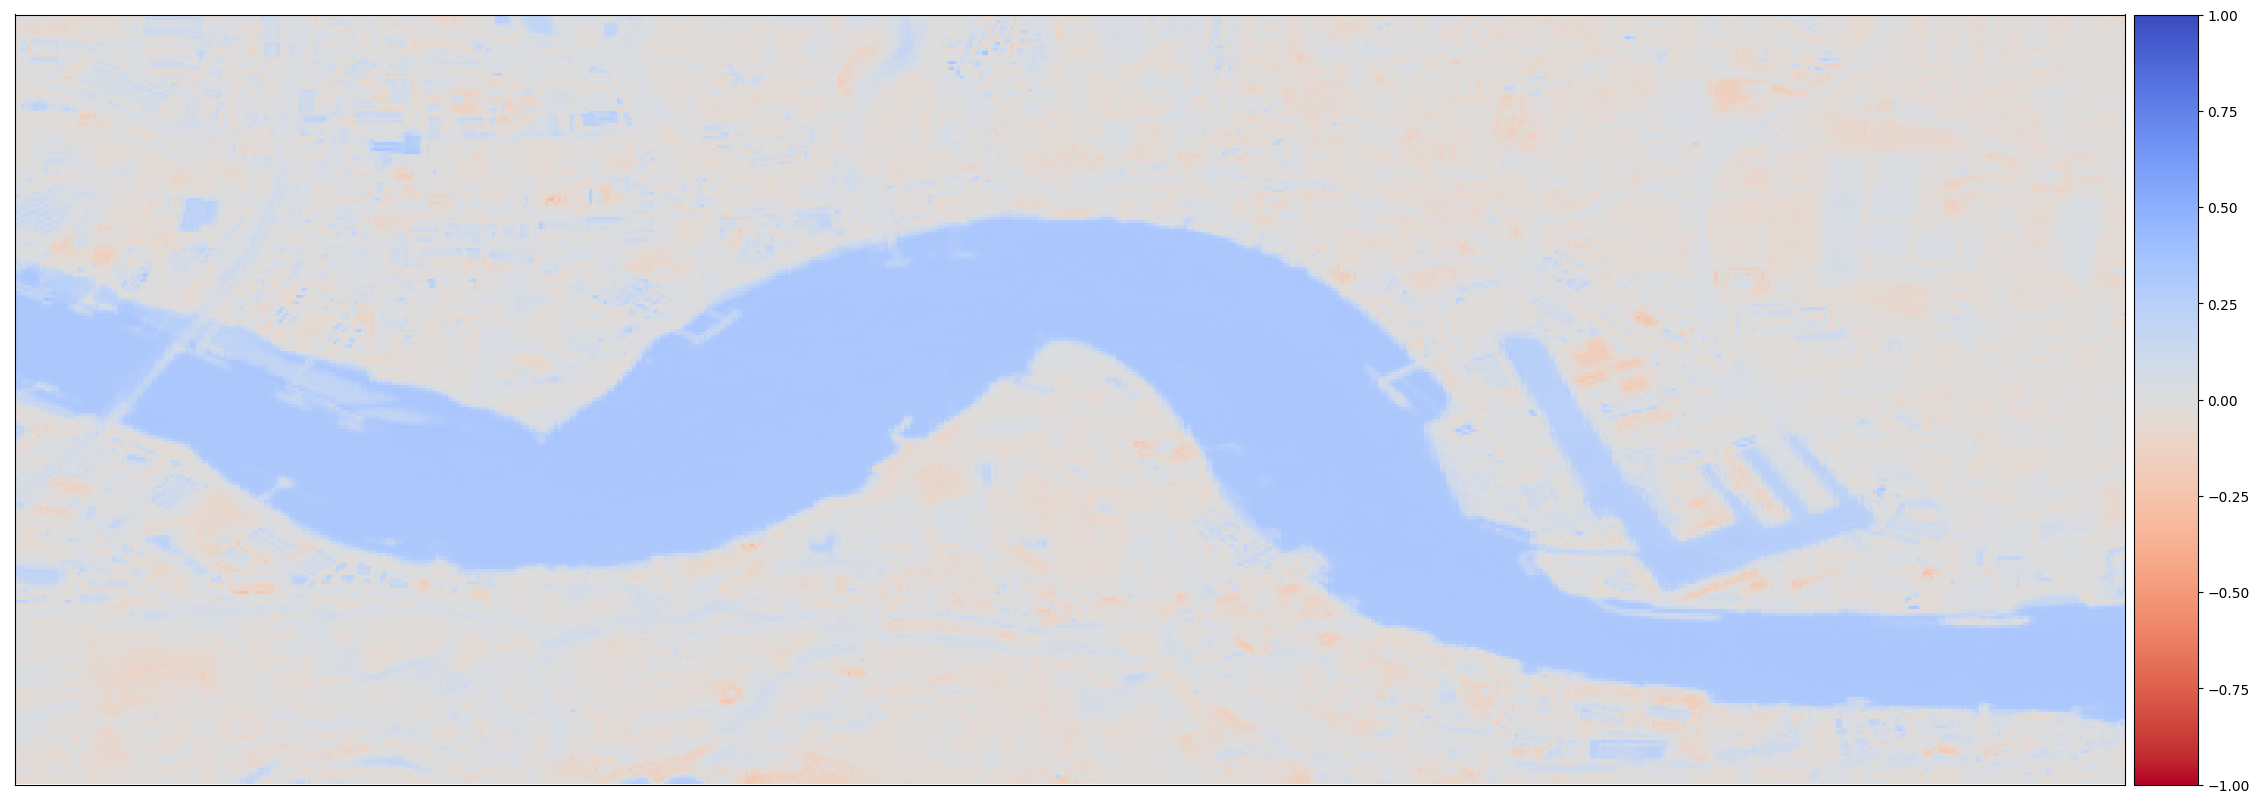

In [122]:
# Green is the 3th band, but 3-1=2 in a python list, starting from 0
# SWIR is the 12th band, but 12-1=11 in a python list, starting from 0
mndwi = es.normalized_diff(arr_bef[2], arr_bef[11])
ep.plot_bands(mndwi,
              cmap="coolwarm_r",
              cols=1,
              vmin=-1,
              vmax=1,
              figsize=(60, 10))
plt.show()